<b>Data Source: Personal Ecommerce Website Ad cost & viewer count, Micheal_Knight.</b> <br>
<b>Retrived from</b> https://www.kaggle.com/datasets/michealknight/personal-ecommerce-website-ad-cost-and-viewer-count 

# Importing Library

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly
import plotly.offline as py
import warnings
warnings.filterwarnings("ignore")

# Preprocess Data

In [215]:
df = pd.read_csv("final_website_stats.csv", parse_dates=True)
df = df.drop(columns=['Unnamed: 0'])
df

,timestamp,page_views,ad_spend,is_weekend,day_of_week,is_holiday
0,2022-01-01,1165.962767,194.901425,True,Saturday,True
1,2022-01-02,1191.485835,175.852071,True,Sunday,False
2,2022-01-03,1266.928269,269.430656,False,Monday,False
3,2022-01-04,1364.193858,295.690896,False,Tuesday,False
4,2022-01-05,1013.282520,242.975399,False,Wednesday,False
...,...,...,...,...,...,...
1091,2024-12-27,1870.700150,248.883333,False,Friday,False
1092,2024-12-28,1977.793002,201.828886,True,Saturday,False
1093,2024-12-29,2229.203908,181.558377,True,Sunday,False
1094,2024-12-30,2286.211502,271.979202,False,Monday,False


<b>Problem to solve: Forecast future page_views</b>

In [218]:
df = df.rename(columns = {'timestamp':'ds', 
                           'page_views':'y'})
df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds')
df = df.asfreq('d')
df.head()

,y,ad_spend,is_weekend,day_of_week,is_holiday
ds,,,,,
2022-01-01,1165.962767,194.901425,True,Saturday,True
2022-01-02,1191.485835,175.852071,True,Sunday,False
2022-01-03,1266.928269,269.430656,False,Monday,False
2022-01-04,1364.193858,295.690896,False,Tuesday,False
2022-01-05,1013.282520,242.975399,False,Wednesday,False


In [219]:
df.isnull().sum()

y              0
ad_spend       0
is_weekend     0
day_of_week    0
is_holiday     0
dtype: int64

# Exploratory Data Analysis

<Axes: title={'center': 'Daily Website View'}, xlabel='ds'>

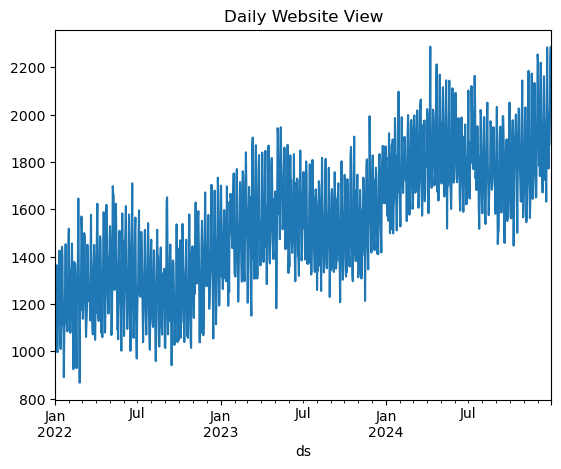

In [223]:
df['y'].plot(title = 'Daily Website View')

This time series shows daily website views from 2022 to 2024, with a clear upward trend and noticeable seasonal fluctuations. Traffic grows steadily over time, with regular spikes and dips suggesting weekly or campaign-based seasonality.

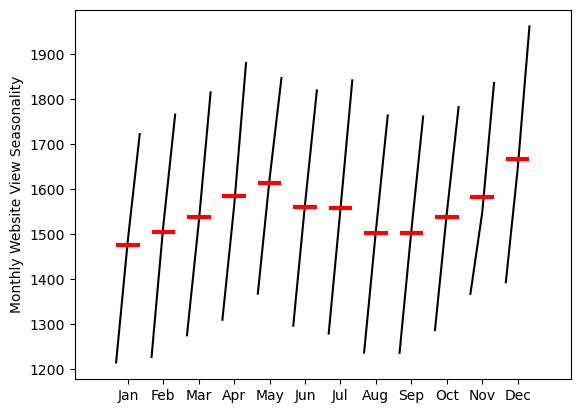

In [225]:
month_plot(df['y'].resample('ME').mean(), ylabel= 'Monthly Website View Seasonality')
plt.show()

 On average, traffic is highest in May and December, while lowest in January. The vertical lines indicate variability, suggesting larger fluctuations during high-traffic months.

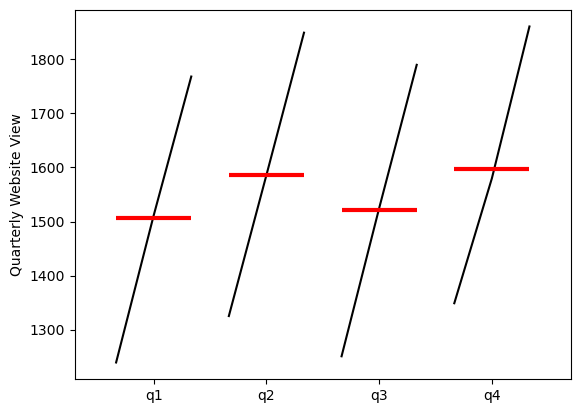

In [227]:
quarter_plot(df['y'].resample('QE').mean(), ylabel = 'Quarterly Website View')
plt.show()

raffic is generally highest in Q2 and Q4, and lowest in Q1. The vertical lines indicate variability within each quarter, with wider ranges in Q2 and Q4 suggesting more fluctuation during those periods.

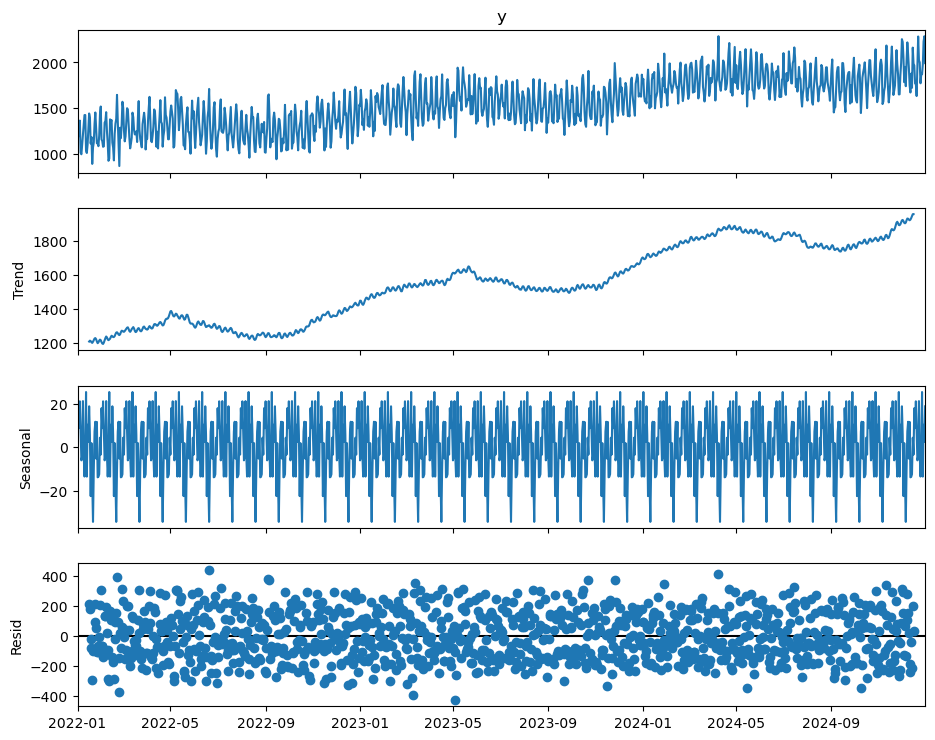

In [230]:
decomposition = seasonal_decompose(df['y'],
                                   model = 'add',
                                   period =30)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

This decomposition shows a clear upward trend, strong and regular seasonality, and fairly random residuals, indicating that the time series is well-structured and suitable for forecasting.

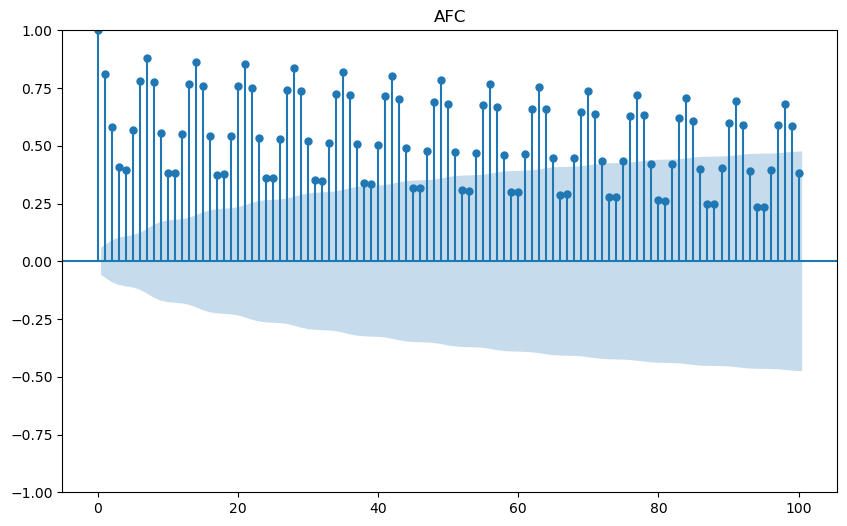

In [233]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.title('AFC')
plt.show()

This repeating pattern roughly every 7 lags is a textbook sign of weekly seasonality — meaning the value of the series today is similar to the same day last week, and so on. Indicate weekly seasonality.

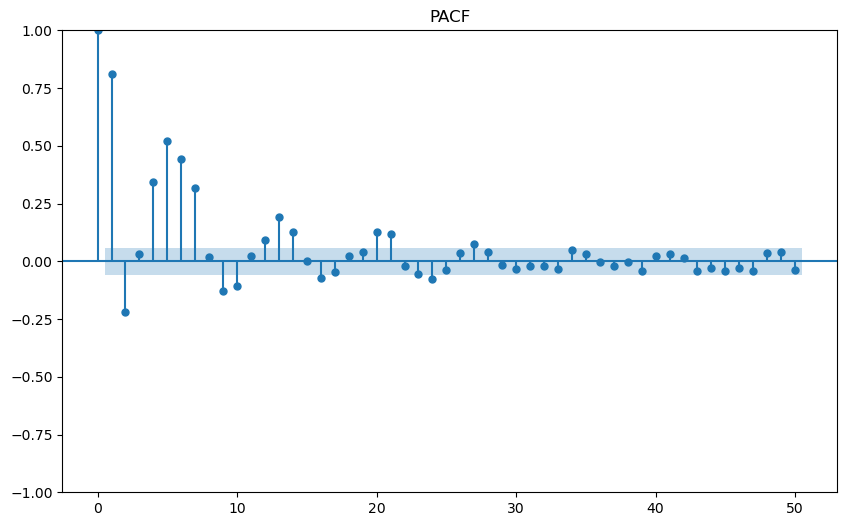

In [236]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 50, ax = ax)
plt.title('PACF')
plt.show()

PACF also confirm which around 7 lags it drop significantly.

# Holidays

In [239]:
df[df.is_holiday==True]

,y,ad_spend,is_weekend,day_of_week,is_holiday
ds,,,,,
2022-01-01,1165.962767,194.901425,True,Saturday,True
2022-07-04,1492.490415,393.296116,False,Monday,True
2022-11-28,1671.390338,373.082369,False,Monday,True
2022-12-25,1491.410599,339.681557,True,Sunday,True
2023-01-01,1522.292648,317.963386,True,Sunday,True
2023-07-04,1580.045980,381.880444,False,Tuesday,True
2023-11-28,1667.429410,518.098562,False,Tuesday,True
2023-12-25,1868.232358,422.297923,False,Monday,True
2024-01-01,1793.077290,405.875358,False,Monday,True


Explain: <br>
01-01: New Year’s Day <br>
07-04: Independence Day <br>
11-28: Spike around this date — likely due to Cyber Monday or Thanksgiving Day <br>
12-25: Christmas Day <br>

In [241]:
df = df.reset_index()  # Prophet doesnt need ds or datetime to be index, but it need separate dataframe for holiday.
gen_holidays = pd.DataFrame({'holiday': 'gen_holi',
                             'ds': df[df.is_holiday == True].ds,
                             'lower_window': -2,
                             'upper_window': 2})

gen_holidays

,holiday,ds,lower_window,upper_window
0,gen_holi,2022-01-01,-2,2
184,gen_holi,2022-07-04,-2,2
331,gen_holi,2022-11-28,-2,2
358,gen_holi,2022-12-25,-2,2
365,gen_holi,2023-01-01,-2,2
549,gen_holi,2023-07-04,-2,2
696,gen_holi,2023-11-28,-2,2
723,gen_holi,2023-12-25,-2,2
730,gen_holi,2024-01-01,-2,2
915,gen_holi,2024-07-04,-2,2


# Feature Engineering

Identify the most influential day of the week to better inform and enhance model training based on weekday behavior.

In [244]:
# Changing boolean into 0 & 1
df.loc[:, 'is_holiday'] = df['is_holiday'].astype(int) 
df.loc[:, 'is_weekend'] = df['is_weekend'].astype(int)
df.head()

,ds,y,ad_spend,is_weekend,day_of_week,is_holiday
0,2022-01-01,1165.962767,194.901425,1,Saturday,1
1,2022-01-02,1191.485835,175.852071,1,Sunday,0
2,2022-01-03,1266.928269,269.430656,0,Monday,0
3,2022-01-04,1364.193858,295.690896,0,Tuesday,0
4,2022-01-05,1013.282520,242.975399,0,Wednesday,0


day_of_week
Monday       1765.094088
Sunday       1712.488934
Tuesday      1614.415242
Saturday     1561.296168
Wednesday    1427.949849
Friday       1411.283898
Thursday     1377.020766
Name: y, dtype: float64


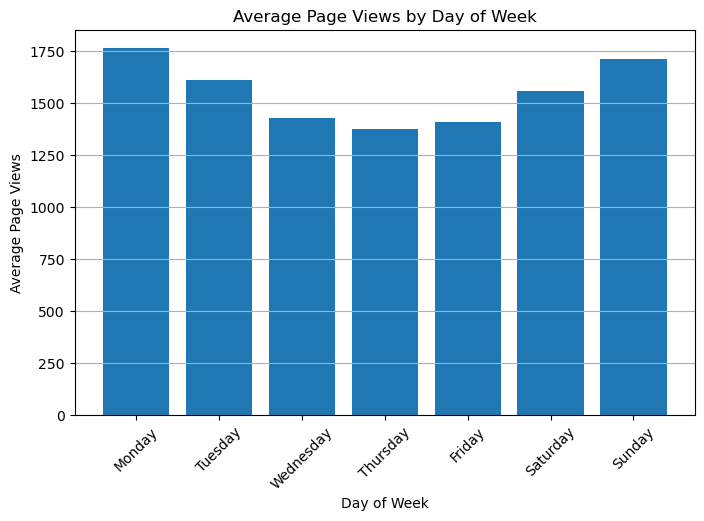

In [245]:
df['day_of_week'] = df['ds'].dt.day_name() 
day_avg = df.groupby('day_of_week')['y'].mean().sort_values(ascending=False)
print(day_avg)


# To maintain weekday order:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.reindex(ordered_days)

plt.figure(figsize=(8, 5))
plt.bar(day_avg.index, day_avg.values)
plt.title("Average Page Views by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Page Views")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


The lowest website view in a weekly mean is at thursday which we will use as variable for regressor and train the model

In [248]:
df.day_of_week.unique() 

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [249]:
df['is_Thursday'] = (df['day_of_week'] == 'Thursday').astype(int)

In [250]:
df[df['day_of_week'] == 'Thursday'].head()

,ds,y,ad_spend,is_weekend,day_of_week,is_holiday,is_Thursday
5,2022-01-06,996.316889,242.975891,0,Thursday,0,1
12,2022-01-13,1010.145995,257.258868,0,Thursday,0,1
19,2022-01-20,891.084071,207.630889,0,Thursday,0,1
26,2022-01-27,1120.738845,215.470193,0,Thursday,0,1
33,2022-02-03,1078.187624,218.268672,0,Thursday,0,1


In [252]:
# see the correlation between y and ad_spend_change
columns = ['y'] + ['is_Thursday'] 
df[columns].corr()

,y,is_Thursday
y,1.000000,-0.259081
is_Thursday,-0.259081,1.000000


# Train Test Split

In [263]:
size = int(len(df)*0.80) #80/20 split
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Parameter Tuning

In [266]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.5],
    'seasonality_prior_scale': [10, 20],
    'holidays_prior_scale': [10, 20],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = list(ParameterGrid(param_grid))
all_params

[{'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 10,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 20,
  'seasonality_mode': 'multiplicative',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.05,
  'holidays_prio

In [289]:
tuning_results = []
for params in all_params:
    # building model
    m = Prophet(yearly_seasonality = True,
            weekly_seasonality = True,
            holidays = gen_holidays,
            ** params)
    m.add_regressor('ad_spend')
    m.add_regressor('is_weekend')
    m.add_regressor('is_holiday')
    m.add_regressor('is_Thursday')
    m.fit(df_train)
    # cross-validation
    df_cv = cross_validation(model = m, 
                                period =  '7 days', 
                                initial = '616 days', 
                                horizon = '30 days',
                                parallel = 'processes')
        # compute and store the error
    rmse = round(performance_metrics(df_cv)['rmse'].mean(),0)
    tuning_results.append(rmse)

outcome = pd.DataFrame(all_params)
outcome['tuning_results'] = tuning_results

09:31:39 - cmdstanpy - INFO - Chain [1] start processing
09:31:39 - cmdstanpy - INFO - Chain [1] done processing
09:31:45 - cmdstanpy - INFO - Chain [1] start processing
09:31:45 - cmdstanpy - INFO - Chain [1] done processing
09:31:52 - cmdstanpy - INFO - Chain [1] start processing
09:31:52 - cmdstanpy - INFO - Chain [1] done processing
09:31:59 - cmdstanpy - INFO - Chain [1] start processing
09:31:59 - cmdstanpy - INFO - Chain [1] done processing
09:32:06 - cmdstanpy - INFO - Chain [1] start processing
09:32:06 - cmdstanpy - INFO - Chain [1] done processing
09:32:13 - cmdstanpy - INFO - Chain [1] start processing
09:32:14 - cmdstanpy - INFO - Chain [1] done processing
09:32:21 - cmdstanpy - INFO - Chain [1] start processing
09:32:21 - cmdstanpy - INFO - Chain [1] done processing
09:32:28 - cmdstanpy - INFO - Chain [1] start processing
09:32:28 - cmdstanpy - INFO - Chain [1] done processing
09:32:36 - cmdstanpy - INFO - Chain [1] start processing
09:32:36 - cmdstanpy - INFO - Chain [1]

In [290]:
outcome

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,tuning_results
0,0.05,10,additive,10,88.0
1,0.05,10,additive,20,88.0
2,0.05,10,multiplicative,10,94.0
3,0.05,10,multiplicative,20,94.0
4,0.05,20,additive,10,88.0
5,0.05,20,additive,20,88.0
6,0.05,20,multiplicative,10,94.0
7,0.05,20,multiplicative,20,94.0
8,0.50,10,additive,10,89.0
9,0.50,10,additive,20,89.0


In [291]:
best_params = all_params[tuning_results.index(min(tuning_results))] #find the lowest
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 10,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

# Prophet Model

In [293]:
# build prophet with the best parameters
m = Prophet(yearly_seasonality = True,
            weekly_seasonality = True,
            holidays = gen_holidays,
            seasonality_mode = 'additive',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('ad_spend')
m.add_regressor('is_weekend')
m.add_regressor('is_holiday')
m.add_regressor('is_Thursday')
m.fit(df_train)

09:33:40 - cmdstanpy - INFO - Chain [1] start processing
09:33:40 - cmdstanpy - INFO - Chain [1] done processing


In [294]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,ad_spend,additive,247.845716,0.265915,0.265915,0.265915
1,is_weekend,additive,0.000000,34.318218,34.318218,34.318218
2,is_holiday,additive,0.000000,-28.628741,-28.628741,-28.628741
3,is_Thursday,additive,0.000000,-41.392673,-41.392673,-41.392673


In [295]:
#interpretation for coef 
def interpret_coefficients(df):
    col_names = df.columns.str.lower()
    regressor_col = next((c for c in df.columns if "regressor" in c.lower()), None)
    coef_col = next((c for c in df.columns if c.lower() == "coef"), None)
    mode_col = next((c for c in df.columns if "mode" in c.lower()), None)

    if not all([regressor_col, coef_col, mode_col]):
        raise ValueError("Required columns not found.")

    interpretations = []
    for _, row in df.iterrows():
        regressor = row[regressor_col]
        coef = row[coef_col]
        mode = row[mode_col]

        if mode.lower() == "multiplicative":
            pct_change = (np.exp(coef) - 1) * 100
            effect = f"increase" if pct_change > 0 else "decrease"
            interpretation = f"For each unit increase in '{regressor}', the target variable is expected to {effect} by {abs(pct_change):.2f}% (multiplicatively)."
        else:
            interpretation = f"For each unit increase in '{regressor}', the target variable changes by {coef:.3f} units (additive)."

        interpretations.append(interpretation)

    return "\n".join(interpretations)

    
coef_df = regressor_coefficients(m).reset_index()  # Reset index in case regressor is stored as index
print(interpret_coefficients(coef_df))


For each unit increase in 'ad_spend', the target variable changes by 0.266 units (additive).
For each unit increase in 'is_weekend', the target variable changes by 34.318 units (additive).
For each unit increase in 'is_holiday', the target variable changes by -28.629 units (additive).
For each unit increase in 'is_Thursday', the target variable changes by -41.393 units (additive).


| regressor     | coef    | interpretation                                                        |
| ------------- | ------- | --------------------------------------------------------------------- |
| `ad_spend`    | +0.295  | Every 1 unit increase in ad spend results in \~0.266 more page views. |
| `is_weekend`  | +35.272 | Page views **increase** by \~34.318 on weekends.                        |
| `is_holiday`  | -37.304 | Page views **decrease** by \~-28.629 on holidays.                        |
| `is_Thursday` | -41.214 | Page views **decrease** by \-41.393 on Thursdays.                       |


# Cross-Validation

In [298]:
df_train.shape[0] - 180

696

In [329]:
df_cv = cross_validation(model = m, 
                         period =  '7 days', 
                         initial = '500 days', #training period from 696 around 196
                         horizon = '30 days',
                         parallel = 'processes')


performance_metrics(df_cv)
mape = round(performance_metrics(df_cv)['mape'].mean() * 100,2)
rmse = round(performance_metrics(df_cv)['rmse'].mean(),0)
print(f'The Mape is {mape} %') 
print(f'The Rmse is {rmse}') 

The Mape is 4.03 %
The Rmse is 84.0


our forecast is off by 4.03% on average.<br>
our forecast is off by 84 view unit on average.

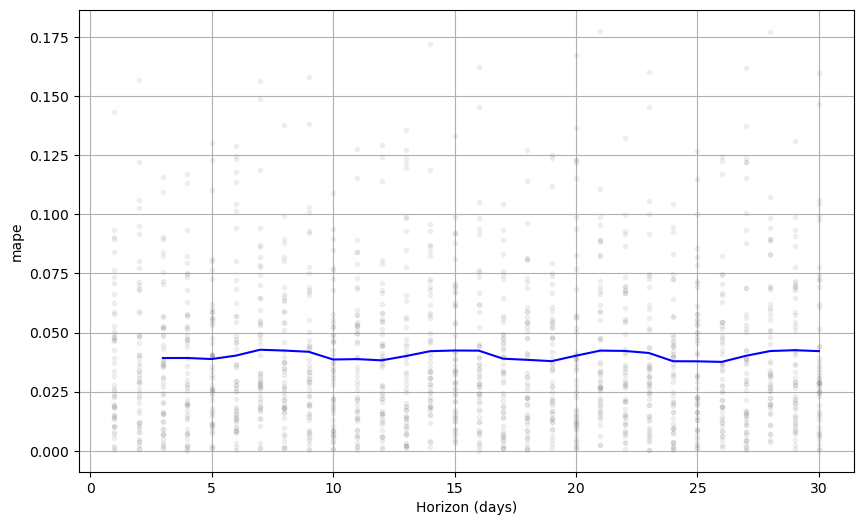

In [332]:
plot_cross_validation_metric(df_cv, metric = 'mape');

 MAPE stays low and stable (~4%) across all forecast horizons (1–30 days), indicating that the model maintains consistent accuracy even for longer-term predictions.

# Forecasting

In [302]:
# Drop columns 'ds' and 'y' from DataFrame df to create future_regressors
future_regressors = df.drop(columns = ['ds', 'y'])
# Drop rows with missing values (NaNs) from future_regressors
future_regressors = future_regressors.dropna()
# Reset the index
future_regressors.reset_index(drop = True, inplace = True)

In [303]:
# Create a future dataframe using Prophet's make_future_dataframe method
future = m.make_future_dataframe(periods = 220) #size of df_test
# Concatenate future dataframe with future_regressors along axis 1 (columns)
future = pd.concat([future, future_regressors], axis = 1)

In [304]:
# Using the Prophet model to generate predictions for future timestamps
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ad_spend,ad_spend_lower,ad_spend_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1091,2024-12-27,1935.545735,1744.490097,1962.902806,1934.783953,1936.274782,0.275918,0.275918,0.275918,-79.386177,...,-148.293751,-148.293751,-148.293751,-6.461529,-6.461529,-6.461529,0.0,0.0,0.0,1856.159558
1092,2024-12-28,1936.255883,1852.577070,2066.481660,1935.490066,1936.992017,-12.236570,-12.236570,-12.236570,12.096856,...,-5.396430,-5.396430,-5.396430,-4.588362,-4.588362,-4.588362,0.0,0.0,0.0,1948.352739
1093,2024-12-29,1936.966031,1984.515927,2212.713539,1936.196244,1937.709115,-17.626805,-17.626805,-17.626805,156.490094,...,142.409904,142.409904,142.409904,-2.611223,-2.611223,-2.611223,0.0,0.0,0.0,2093.456125
1094,2024-12-30,1937.676179,2048.584130,2260.707536,1936.902668,1938.423471,6.417459,6.417459,6.417459,217.218194,...,211.324022,211.324022,211.324022,-0.523287,-0.523287,-0.523287,0.0,0.0,0.0,2154.894373
1095,2024-12-31,1938.386327,1888.811052,2101.139204,1937.609092,1939.136953,-0.071056,-0.071056,-0.071056,58.951981,...,57.343215,57.343215,57.343215,1.679822,1.679822,1.679822,0.0,0.0,0.0,1997.338308


# Data visualization

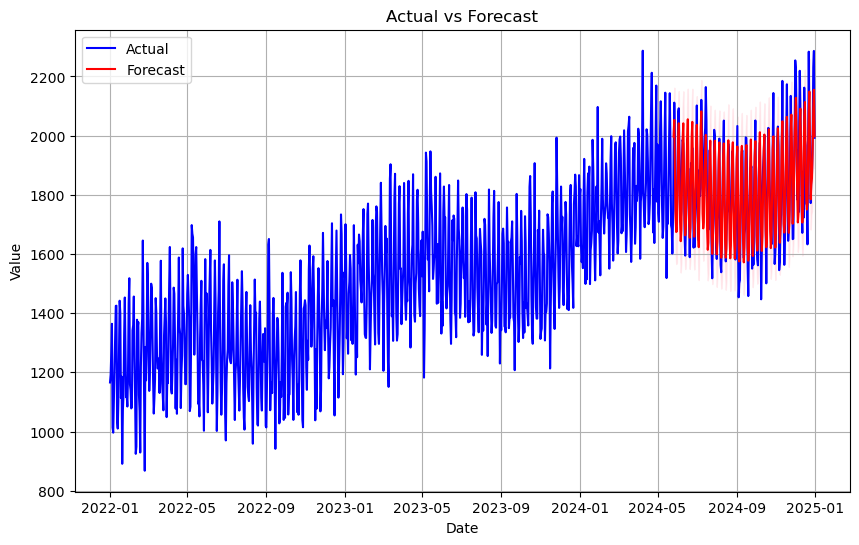

In [306]:
# Filter the forecast only for the test period
forecast_test = forecast[forecast['ds'].isin(df_test['ds'])]

# Plot
plt.figure(figsize=(10, 6))

# Actual full data
plt.plot(df['ds'], df['y'], label='Actual', color='blue')

# Forecasted values only for test period
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='red')

# Confidence interval
plt.fill_between(forecast_test['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='pink', alpha=0.3)

# Labels
plt.title("Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


The forecast closely follows the recent trend, showing a slight dip and recovery, with reasonable uncertainty bounds. It suggests the model generalizes well and captures seasonal patterns into the unseen test data.

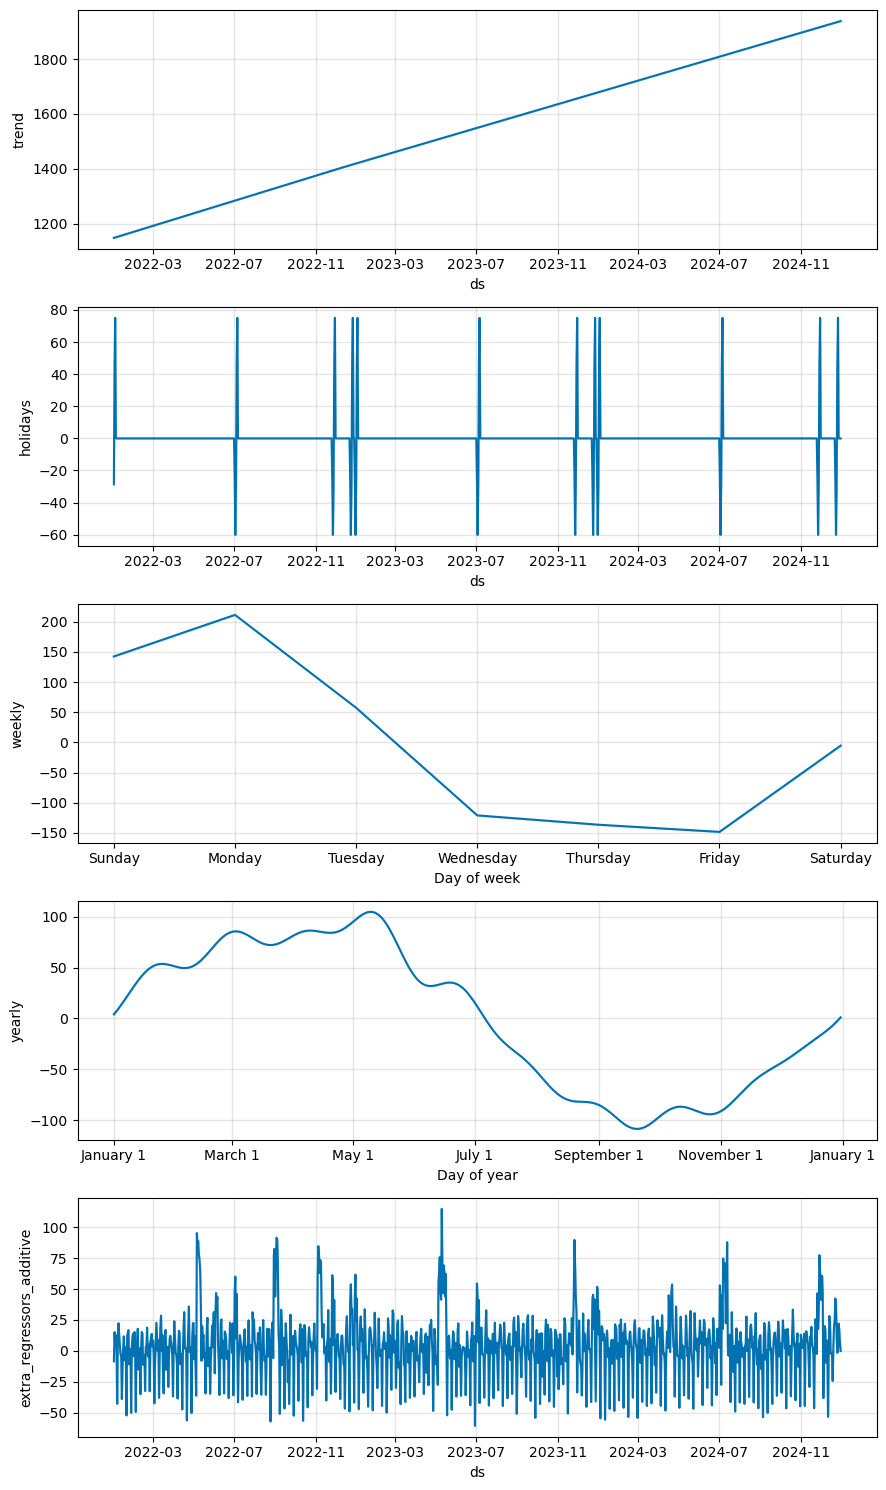

In [307]:
# Visualize components plot
# 1. Trend: Shows the overall trend of the time series over time.
# 2. Holidays : Shows the effect of holidays on the forecast.
# 3. Weekly Seasonality: Shows patterns that repeat weekly.
# 4. Yearly Seasonality: Displays patterns that repeat annually.
# 4. Other Regressors: Displays the impact of additional regressors added to the model.
m.plot_components(forecast)
plt.show()

<b>Trend:</b> Website views steadily increase over time. <br>
<b>Holidays</b> Certain holidays cause sharp spikes or drops in traffic. <br>
<b>Weekly:</b> Highest traffic occurs on Mondays, lowest around Thursdays–Fridays. <br>
<b>Yearly:</b> Peaks around March–May, dips in August–October. <br>
<b>Extra Regressor (ad_spend):</b> Shows a frequent but irregular impact across the timeline.

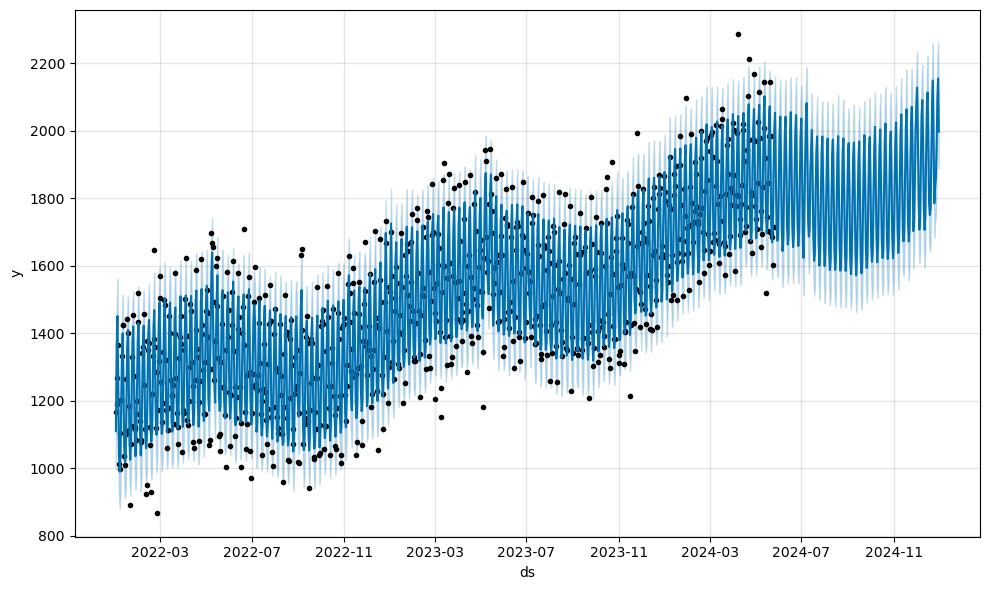

In [308]:
# Visualize forecast plot with uncertainty bounds
m.plot(forecast)
plt.show()

The model closely follows the actual data trend, and most observed values fall within the shaded prediction range, indicating strong forecasting accuracy.

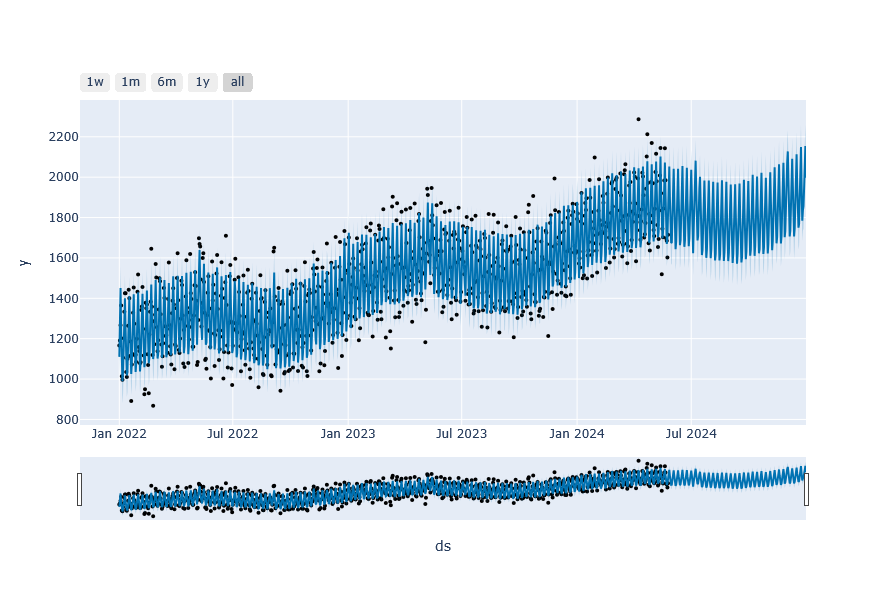

In [309]:
# Use Prophet's plot_plotly function to generate an interactive plotly figure
fig = plot_plotly(m, forecast)
# Use Plotly's offline mode to display the interactive plotly figure
py.iplot(fig)